# Import Module

In [1]:
!pip install wordcloud 

In [11]:
import pandas as pd 
import numpy as np 

#import nltk for natural language toolkit
import nltk 
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords


#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\okky.qomarudin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Preparation

In [39]:
#iport dataset 
dataset = pd.read_csv('dataset/drugsComTrain_raw.tsv', sep='\t')
dataset.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [40]:
#get text and response 
df = dataset[['review','rating']]

## A. Preprocessing 

### A.1. Data Cleansing

In [41]:
#cleansing 
def preprocessing(text):
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    def remove_between_square_brackets(text):
        return re.sub('-\[[^]]*\]', '', text)
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        return text
    def remove_punctuation(text):
        return re.sub(r'[^\w\s]', '', text)
    def remove_non_ascii(text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    
    return text.lower()

In [42]:
# #apply function 
df['review'] = df['review'].progress_apply(preprocessing)

100%|████████████████████████████████| 161297/161297 [00:18<00:00, 8804.42it/s]
C:\Users\okky.qomarudin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
# stopwords.words('indonesian')

### A.2. Preprocessing

In [45]:
#stopword 
stop = stopwords.words('english')
df['review'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

C:\Users\okky.qomarudin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
!pip install nltk

In [ ]:
nltk.download('wordnet')

In [48]:
#lematization 
df['review']  = df['review'] .apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

C:\Users\okky.qomarudin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### A.2. Data Exploration

In [49]:
#count sentiment 
sentiment = df.groupby(['rating'])['rating'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['rating'] = chart['rating']
chart.drop(['rating'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['rating']/chart['rating'].sum()
chart

,rating,percent
0,1.0,0.018182
1,2.0,0.036364
2,3.0,0.054545
3,4.0,0.072727
4,5.0,0.090909
5,6.0,0.109091
6,7.0,0.127273
7,8.0,0.145455
8,9.0,0.163636
9,10.0,0.181818


#### 1. Barchart

Text(0.5, 1.0, 'Sentiment Class')

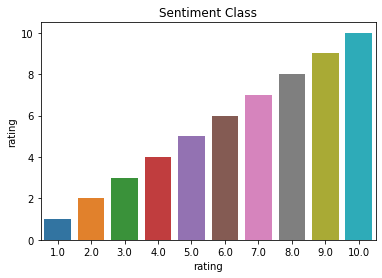

In [50]:
#visualization 
ax = sns.barplot(x= 'rating', y='rating', data=chart)
ax.set_title('Sentiment Class')

#### 2. Wordcloud

In [51]:
#define happy and not happy 
happy = df.loc[df['rating'] >= 7 ]
not_happy  = df.loc[df['rating'] < 7]

In [52]:
#merge all the happy comments into one paragraph
all_description_happy = "".join(happy.review.values)
all_description_not_happy = "".join(not_happy.review.values)

In [53]:
#text = happy.Description
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

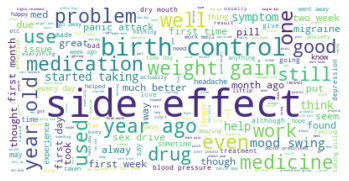

In [54]:
#happy 
create_word_cloud(all_description_happy)

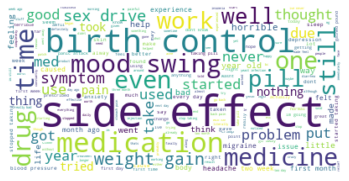

In [55]:
#nothappy
create_word_cloud(all_description_not_happy)

## B. Feature Extraction

### 1. Count Vectorizer 

In [56]:
count_vectorizer = CountVectorizer(stop_words='english')

### 1. TF-IDF vectorizer 

In [57]:
tfidf = TfidfVectorizer(stop_words='english')

## C. Modeling 

### 1. Train Test Split

In [59]:
X = df['review']
y = df['rating']

In [60]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

In [61]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

### 2. Model Machine Learning

In [62]:
# a. Logistic regression
# b. Naive Bayes

#### a. Logistic Regression

In [ ]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

C:\Users\okky.qomarudin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\okky.qomarudin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

#### b. Naive Bayes

In [ ]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [ ]:
# TFIDFVectorizer
#from sklearn.naive_bayes import GaussianNB
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

#### c. Another Algorithm

In [ ]:
#

### 3. Model Evaluation

The following option are kind of model evaluation that used.  
- Precision = precision_score()
- Recall = recall_score() 
- F_measure = f1_score()

#### a. Logistic Regression

In [ ]:
# using count vectorizer
print("______________ Countvectorizer ______________")

# Lr_clf_vec_report_train = classification_report(train_y, Lr_pred_vect_train)
# Lr_clf_vec_report_test = classification_report(test_y, Lr_pred_vect_test)

# Lr_confmatrix_vect_train = confusion_matrix(train_y, Lr_pred_vect_train) 
# Lr_confmatrix_vect_test = confusion_matrix(test_y, Lr_pred_vect_test)

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Information :')
# print('Confusion matrix for Train :')
# print(Lr_confmatrix_vect_train,'\n')
# print('Confusion matrix for Test :')
# print(Lr_confmatrix_vect_test,'\n')
# print('Classification Refort for Train :')
# print(Lr_clf_vec_report_train,'\n')
# print('Classification Refort for Test :')
# print(Lr_clf_vec_report_test,'\n')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

In [ ]:
# using count vectorizer
print("______________ TF-IDF ______________")


Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

#### b. Naive Bayes

In [ ]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")


NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

In [ ]:
# using count vectorizer
print("______________ TF-IDF ______________")


NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

#### c. Another Alogirthm

In [ ]:
#lets try by yourself 